We want to understand the time dependence of the data. To do so, we try to use Gaussian Processes from GPFlow, which is powered by TensorFlow.

In [12]:
# import libs && tools
import numpy as np
import pandas as pd
import gpflow
import matplotlib
from scipy.spatial.distance import pdist, squareform
import scipy
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,6)
plt = matplotlib.pyplot

In [3]:
# import and handle data
df = pd.read_csv('../data/20190606180000-20190606190000.csv')
df=df.replace([np.inf, -np.inf], np.nan)
df=df.dropna();
df=df.round(decimals=5)  # round to one decimal after precision of devices
df['diff'] = (df['B_VIMIN'] - df['B:VIMIN'])
df2= pd.DataFrame({'diff' : df['diff'], 'err' : df['B:IMINER']})
col1,col2,col3,col4='B:IMINER','B:VIMIN','B_VIMIN', 'B_VIMAX'

C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (77,79,81,83,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# define period of TLG
horizon = 61.4; # unit: sec. horizon of TLG..61.-- sec
cycle   = 15; # 15Hz sampling
supercycle = int(cycle*horizon);

num_train = 1*supercycle

In [5]:
df3 = df

In [6]:
df3 = df3[df3.columns[::2]]
df3.head()

,Unnamed: 0,B:VIMIN,B_VIMIN,B:VIMAX,B_VIMAX,B:IMINER,B:NGMPS,B:VINHBT,B:GMPSFF,B:GMPSBT,...,B:GMPS1V,B:PS2VGP,B:PS2VGM,B:GMPS2V,B:PS3VGP,B:PS3VGM,B:GMPS3V,B:PS4VGP,B:PS4VGM,B:GMPS4V
0,0,102.52424,102.53089,965.69336,965.68463,0.07469,4.0,1.0,0.1,0.0003,...,29.16878,20.63779,-20.96279,166.96892,17.46854,-21.53099,77.63445,10.96862,-29.33090,43.83442
1,1,102.52985,102.53089,965.63391,965.68463,0.01469,4.0,1.0,0.1,0.0003,...,120.81887,19.33777,-20.96279,75.96883,17.46854,-21.53099,77.63445,10.96862,-29.33090,43.83442
2,2,102.53791,102.53089,965.70276,965.68463,-0.07031,4.0,1.0,0.1,0.0003,...,147.46890,20.63779,-19.66278,115.61887,16.16856,-24.13096,39.28441,12.26860,-30.63088,8.73438
3,3,102.53330,102.53089,965.65582,965.68463,-0.02031,4.0,1.0,0.1,0.0003,...,107.16886,19.33777,-19.66278,56.46881,16.16856,-24.13096,39.28441,12.26860,-30.63088,8.73438
4,4,102.53393,102.53089,965.71838,965.68463,-0.02031,4.0,1.0,0.1,0.0003,...,80.51883,18.03775,-20.96279,56.46881,16.16856,-25.43094,11.33439,10.96862,-29.33090,171.23455


In [7]:
df3=df3.drop(columns = [col1, col2])

In [20]:
df3.head()
obs_vars = [s for s in df3.columns if ":" in s]
df3=df3.drop(columns = obs_vars)

In [21]:
df3.head()

,B_VIMIN,B_VIMAX,B_VINHBT,B_GMPSFF,B_GMPSBT,B_IMINST,B_IPHSTC,B_IMINXG,B_IMINXO,B_IMAXXG,B_IMAXXO,B_ACMNPG,B_ACMNIG,B_ACMXPG,B_ACMXIG,B_DCPG,B_DCIG,B_VIPHAS
0,102.53089,965.68463,1.0,0.1,0.0003,0.0,20.0,-11.185,0.0,-112.855,10.0,8.5,0.7535,3.0,0.3,0.0,0.0,1.81
1,102.53089,965.68463,1.0,0.1,0.0003,0.0,20.0,-11.185,0.0,-112.855,10.0,8.5,0.7535,3.0,0.3,0.0,0.0,1.81
2,102.53089,965.68463,1.0,0.1,0.0003,0.0,20.0,-11.185,0.0,-112.855,10.0,8.5,0.7535,3.0,0.3,0.0,0.0,1.81
3,102.53089,965.68463,1.0,0.1,0.0003,0.0,20.0,-11.185,0.0,-112.855,10.0,8.5,0.7535,3.0,0.3,0.0,0.0,1.81
4,102.53089,965.68463,1.0,0.1,0.0003,0.0,20.0,-11.185,0.0,-112.855,10.0,8.5,0.7535,3.0,0.3,0.0,0.0,1.81


In [22]:
np.random.seed(1)
X = np.random.rand(num_train,df3.shape[1]) 
X2 = np.array(df3[:num_train].values)
#np.array(df[[col1,col2]][:num_train].values)#,df[col2][:num_train].values)
X2.shape
#X[:][0] = df[col1][:num_train].values
X[:,:] =  df3[:num_train].values

In [23]:
pairwise_dists = squareform(pdist(X, 'euclidean'))
sig = 0.001
K = scipy.exp(-pairwise_dists ** 2 / sig ** 2)
f = np.dot(np.linalg.cholesky(K), np.random.randn(X.shape[0],1))
f[:,0] =  df[col1][:num_train].values

plt.plot(X, f, '.')
plt.ylabel('latent function value')

Y = f;#np.round((f + f.min())*3)
Y = Y #- Y.min()
Y = np.asarray(Y, np.float64)


plt.twinx()
plt.plot(X, Y, 'kx', mew=1.5)
plt.ylabel('observed data value')

LinAlgError: Matrix is not positive definite

In [17]:
# construct ordinal likelihood
bin_edges = np.array(np.arange(np.unique(Y).size + 1), dtype=float)
bin_edges = bin_edges - bin_edges.mean()
likelihood=gpflow.likelihoods.Ordinal(bin_edges)

# build a model with this likelihood
m = gpflow.models.VGP(X, Y,
                   kern=gpflow.kernels.Matern32(1),
                   likelihood=likelihood)

#fit the model
gpflow.train.ScipyOptimizer().minimize(m)

W0617 09:26:07.374155  2376 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\gpflow\core\node.py:109: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 09:26:07.437163  2376 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\gpflow\params\parameter.py:385: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 09:26:07.452788  2376 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\gpflow\params\parameter.py:391: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0617 09:26:09.925185  2376 deprecation.py:323] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\tensorflow\python\ops\array_grad.py:199: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instr

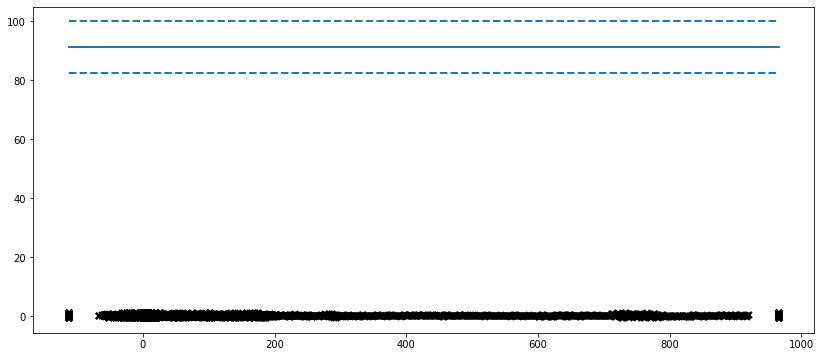

In [18]:
plt.figure(figsize=(14, 6))
Xtest = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 100).reshape(-1, 1)
mu, var = m.predict_y(Xtest)
line, = plt.plot(Xtest, mu, lw=2)
col=line.get_color()
plt.plot(Xtest, mu+2*np.sqrt(var), '--', lw=2, color=col)
plt.plot(Xtest, mu-2*np.sqrt(var), '--', lw=2, color=col)
plt.plot(m.X.read_value(), m.Y.read_value(), 'kx', mew=2)

In [8]:
# to see the predictive density, try predicting every possible value.
def pred_density(m):
    Xtest = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 100).reshape(-1, 1)
    ys = np.arange(m.Y.read_value().max()+1)
    densities = []
    for y in ys:
        Ytest = np.ones_like(Xtest) * y
        densities.append(m.predict_density(Xtest, Ytest))
    return np.hstack(densities).T

C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Attempting to set identical left == right == 965.68463 results in singular transformations; automatically expanding.
  This is separate from the ipykernel package so we can avoid doing imports until


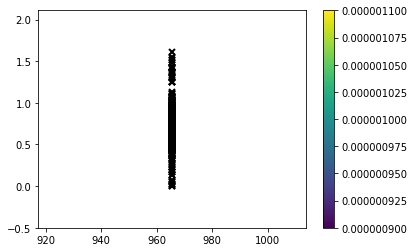

In [9]:
plt.imshow(np.exp(pred_density(m)), interpolation='nearest',
           extent=[m.X.read_value().min(), m.X.read_value().max(), -0.5, m.Y.read_value().max()+0.5],
           origin='lower', aspect='auto', cmap=plt.cm.viridis)
plt.colorbar()
plt.plot(X, Y, 'kx', mew=2, scalex=False, scaley=False)